## Normalized to 1

In [2]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [5]:
alpha = 1
%timeit random.betavariate(alpha, alpha)

2.24 µs ± 44.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
alpha = 2
%timeit random.betavariate(alpha, alpha)

5.19 µs ± 45.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
class StochasticFragmentation:
    def __init__(self, alpha, prob):
        """
        alpha : 
        prob  : probability of keeping the right segment
        """
        self.alpha            = alpha
        self.prob             = prob
        self.expon            = 2*alpha - 1
        self.normC            = 1.0 # normalization constant
        self.probability_list = [1.0]
        self.length_list      = [1.0]
        self.flag_list        = [True]
        self.choose_pivot     = self.betadist
        pass

    def reset(self):
        self.normC            = 1.0 # normalization constant
        self.probability_list = [1.0]
        self.length_list      = [1.0]
        self.flag_list        = [True]
        
    def set_pivot_choosing_method(self, method='logistic'):
        """
        method  : way to choose the pivot point of a given segment
        returns : random value in [0, 1]
        """
        if method is 'logistic':
            self.choose_pivot = self.logistic_choice
            pass
        self.choose_pivot = self.betadist
        pass
    
    def betadist(self):
        """gives a random number from beta distribution"""
#         print("betadist")
        return random.betavariate(self.alpha,self.alpha)
    
    def logistic_xn(self, n, a=2):
        x0 = random.random()
        x1 = 0
        if n < 0:
            print("n cannot be negative")
            n = 1
            pass
        for i in range(n):
            x1 = a * x0 * (1-x0)
            x0 = x1
            pass
        return x0

    def logistic_choice(self):
#         print("logistic_choice")
        beta = self.alpha - 1
        RR = self.logistic_xn(beta)
        RRp = 1 - RR
        r = random.random()
        if r < 0.5:
            return RR
        return RRp
    
        
    def decision(self):
        """
        decides with a given probability whether to keep the right part
        """
        if self.prob > random.random():
            return True
        else: 
            return False
        
    def splitting(self, segment):
        """
        splits a given segment. left and right are endpoints of the segment
        segment : length of a segment
        returns : 
            xL -> length of the left segment
            xR -> length of the right segment
            flag -> keeping the right segment
            xLp, xRp -> probability(unnormalized) for being selected
            change -> change of normalization const
        """
        xL = segment * self.choose_pivot()
        xR = segment - xL
        flag = self.decision()
        xLp = xL**self.expon
        xRp = xR**self.expon
        change = xLp + xRp - segment**self.expon
        return xL, xR, flag, xLp, xRp, change
    
    def pickindex(self):
        """
        picks up a segment to be subsequently split
        """
        r = random.uniform(0, 1)
        sum_ = 0
        for index in range(len(self.probability_list)):
            sum_ += self.probability_list[index]/self.normC
            if sum_ < r:
                continue
            else:
                return index
            pass
        print("out of range. return None")
        pass
    
    def number_length(self):

        lengths = np.array(self.length_list)
        lengths = lengths[self.flag_list]
        N = lengths.shape[0]
        M = np.sum(lengths)
        
#         M, N = 0, 0
#         for i in range(len(self.flag_list)):
#             if self.flag_list[i]:
#                 N += 1
#                 M += self.length_list[i]
#                 pass
#             pass
#         if abs(M1-M) > 1e-10:
#             print("not equal")
        return N, M
    
    
    def view(self):
        print("viewing status")
        print("alpha = ", self.alpha)
        print("keeping probability ", self.prob)
        print("<length> <flag> <probability>")
        for i in range(len(self.length_list)):
            print("{:.5e}, {:.5e}, {:5}".format(self.length_list[i],
                                            self.probability_list[i]/self.normC,
                                            self.flag_list[i]
                                            ))
            pass
        print(np.sum(self.length_list))
        print(np.sum(self.length_list))
        pass
    
    def one_time_step(self):
        index = self.pickindex()
        if (type(index) == int) and self.flag_list[index]:

            xL, xR, flag, xLp, xRp, change = self.splitting(self.length_list[index])

            self.length_list[index] = xL
            self.length_list.append(xR)
            self.flag_list.append(flag)
            self.probability_list[index] = xLp 
            self.probability_list.append(xRp)
            self.normC += change
            pass
        
        pass
    
    
    def run(self, total_iteration, min_iteration, iteration_step):
        iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
        N_realization = []
        M_realization = []

        for i in range(total_iteration + 1):
#             print("time step ", i)
            self.one_time_step()

            if i+1 in iteration_list:
                N, M = self.number_length()
                N_realization.append(N)
                M_realization.append(M)
            pass

        N_list = np.array(N_realization)
        M_list = np.array(M_realization)

        return N_list, M_list

In [23]:
a = StochasticFragmentation(2, 0.75)

In [24]:

a.one_time_step()
a.view()

viewing status
alpha =  2
keeping probability  0.75
<length> <flag> <probability>
7.50486e-01, 9.64553e-01,     1
2.49514e-01, 3.54473e-02,     1
1.0
1.0


In [25]:
def realization_value(total_iteration, min_iteration, iteration_step):
    iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
    N_realization = []
    M_realization = []
    a = StochasticFragmentation(2, 0.75)
    for i in range(total_iteration + 1):
    #             print("time step ", i)
        a.one_time_step()

        if i+1 in iteration_list:
            N, M = a.number_length()
            N_realization.append(N)
            M_realization.append(M)
        pass

    N_list = np.array(N_realization)
    M_list = np.array(M_realization)

    return N_list, M_list

In [26]:
%timeit realization_value(10000, 5000, 500)

36.4 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit a.one_time_step()

3.57 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
%timeit a.run(10000, 5000, 500)

41.3 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def ensemble_average(total_iteration = 1000, min_iteration = 100, iteration_step = 100, ensemble_size = 1000):

    data_points = int ((total_iteration - min_iteration)/iteration_step + 1)
    N_ensemble = np.zeros(data_points)
    M_ensemble = np.zeros(data_points)
    step = ensemble_size // 100
    a = StochasticFragmentation(2, 0.75)
    for i in range(ensemble_size):
        a.reset()
        if i % step == 0:
            print("iteration ", i)
        N_list, M_list = a.run(total_iteration, min_iteration, iteration_step)
        N_ensemble += N_list
        M_ensemble += M_list
        pass
    
    N_average = N_ensemble/ensemble_size
    M_average = M_ensemble/ensemble_size
    
    return N_average, M_average

In [30]:
N_average, M_average = ensemble_average(100_000, 50_000, 5_000, 500)

iteration  0
iteration  5
iteration  10
iteration  15
iteration  20
iteration  25
iteration  30
iteration  35
iteration  40
iteration  45
iteration  50
iteration  55
iteration  60
iteration  65
iteration  70
iteration  75
iteration  80
iteration  85
iteration  90
iteration  95
iteration  100
iteration  105
iteration  110
iteration  115
iteration  120
iteration  125
iteration  130
iteration  135
iteration  140
iteration  145
iteration  150
iteration  155
iteration  160
iteration  165
iteration  170
iteration  175
iteration  180
iteration  185
iteration  190
iteration  195
iteration  200
iteration  205
iteration  210
iteration  215
iteration  220
iteration  225
iteration  230
iteration  235
iteration  240
iteration  245
iteration  250
iteration  255
iteration  260
iteration  265
iteration  270
iteration  275
iteration  280
iteration  285
iteration  290
iteration  295
iteration  300
iteration  305
iteration  310
iteration  315
iteration  320
iteration  325
iteration  330
iteration  335
it

0.7748057128964836


Text(0, 0.5, 'ln N')

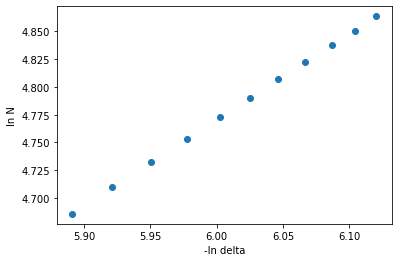

In [31]:
N_log = np.log(N_average)
minus_delta_log = N_log - np.log(M_average)
slope, intercept = np.polyfit(minus_delta_log, N_log, 1)
print(slope)
plt.plot(minus_delta_log, N_log, "o")
plt.xlabel("-ln delta")
plt.ylabel("ln N")
# plt.show()

0.7784419246258479


Text(0, 0.5, 'ln N')

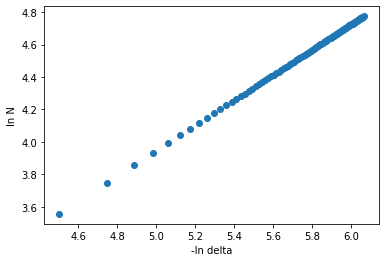

In [12]:
N_log = np.log(N_average)
minus_delta_log = N_log - np.log(M_average)
slope, intercept = np.polyfit(minus_delta_log, N_log, 1)
print(slope)
plt.plot(minus_delta_log, N_log, "o")
plt.xlabel("-ln delta")
plt.ylabel("ln N")
# plt.show()
print(0.7784419246258479)

## Testing

In [15]:
def f():
    arr = [   ]
    for a in range(1000):
        arr.insert(0, a)
    return arr

In [16]:
%timeit f()

323 µs ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
def g():
    arr = [0]*1000
    i = 1000-1
    for a in range(1000):
        arr[i] = a
        i -= 1
    return arr

In [18]:
%timeit g()

86.2 µs ± 7.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
685/129

5.310077519379845

In [20]:
np.array(f())

array([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987,
       986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974,
       973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961,
       960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948,
       947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935,
       934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922,
       921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909,
       908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896,
       895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883,
       882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870,
       869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857,
       856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844,
       843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831,
       830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 81

In [21]:
np.array(g())

array([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987,
       986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974,
       973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961,
       960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948,
       947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935,
       934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922,
       921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909,
       908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896,
       895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883,
       882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870,
       869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857,
       856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844,
       843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831,
       830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 81

## Idea to make it faster

1. each insert takes 5 times more time than just assigining value. because "insert" method inserts in some ranodm position 
2. same is not true for append. appends always inserts at the end
3. so we only need to replace insert method with something else
4. if we can find something where ordering or sequencing does not matter, this will be resolved
5. instead of points we can work with segment length only. and corresponding flag and probability. Like the table bellow

| length  | flag  | probability  |
|---|---|---|
|   |   |   |
|   |   |   |  
|   |   |   | 

7. Probably this can be made even faster by not using append in each iteration

# Performance
| method  | time
|---|---|
realization_value    | $1.19$ s
realization_value_v2 | $241$ ms

realization_value_v2 is $~5$ times faster

# Results
1. slope with realization_value    $0.779388458353189$
2. slope with realization_value_v2 $0.7841054354669876$


In [34]:
index = 1
type(index) == int

True

In [35]:
type(int)

type

In [36]:
type

type

In [37]:
type(type)

type